In [1]:
import numpy as np
import pandas as pd
import pyrsm as rsm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Croq'Pain

You can find the Croq'Pain case on pages 299-306 in the textbook, _Data, Models, and Decisions_. Please use the data set provided and not the data from the book.

`CroqPain.parquet` is the full data set that includes all stores as well as a set of 10 potential new store locations. Below, we provide some extra guidance as you work through each part of the case.

In [2]:
croq_df = pd.read_parquet('CroqPain.parquet')
croq_md = open('CroqPain_description.md')
croq_desc = croq_md.read()
croq_df.head()

,STOR,EARN,K,SIZE,EMPL,total,P15,P25,P35,P45,P55,INC,COMP,NCOMP,NREST,PRICE,CLI,CITY
0,1,28339.672620,861.0718,129,14.0,8.58,0.98,1.28,0.56,1.00,3.10,27.6,8,1,45,16.1,129,
1,2,-1.455001,630.3028,91,12.0,8.46,1.29,0.72,1.20,1.49,3.10,28.3,2,2,27,11.4,116,
2,3,68.932678,1074.4360,140,13.0,19.25,2.94,2.49,3.71,4.03,5.27,30.2,5,4,5,21.7,142,
3,4,202.073327,882.0064,184,7.0,20.92,3.57,4.93,4.42,4.30,2.96,27.6,2,1,7,11.8,138,
4,5,115.778511,930.6688,144,14.0,11.66,1.70,1.14,2.20,2.14,2.63,33.9,1,3,25,16.6,126,


### Before you start ...

There is a problem in the data file `CroqPain.parquet` (i.e., the data needs some 'cleaning'). Find the issue and propose a fix before you continue with the analysis.

* Hint: Check data histograms

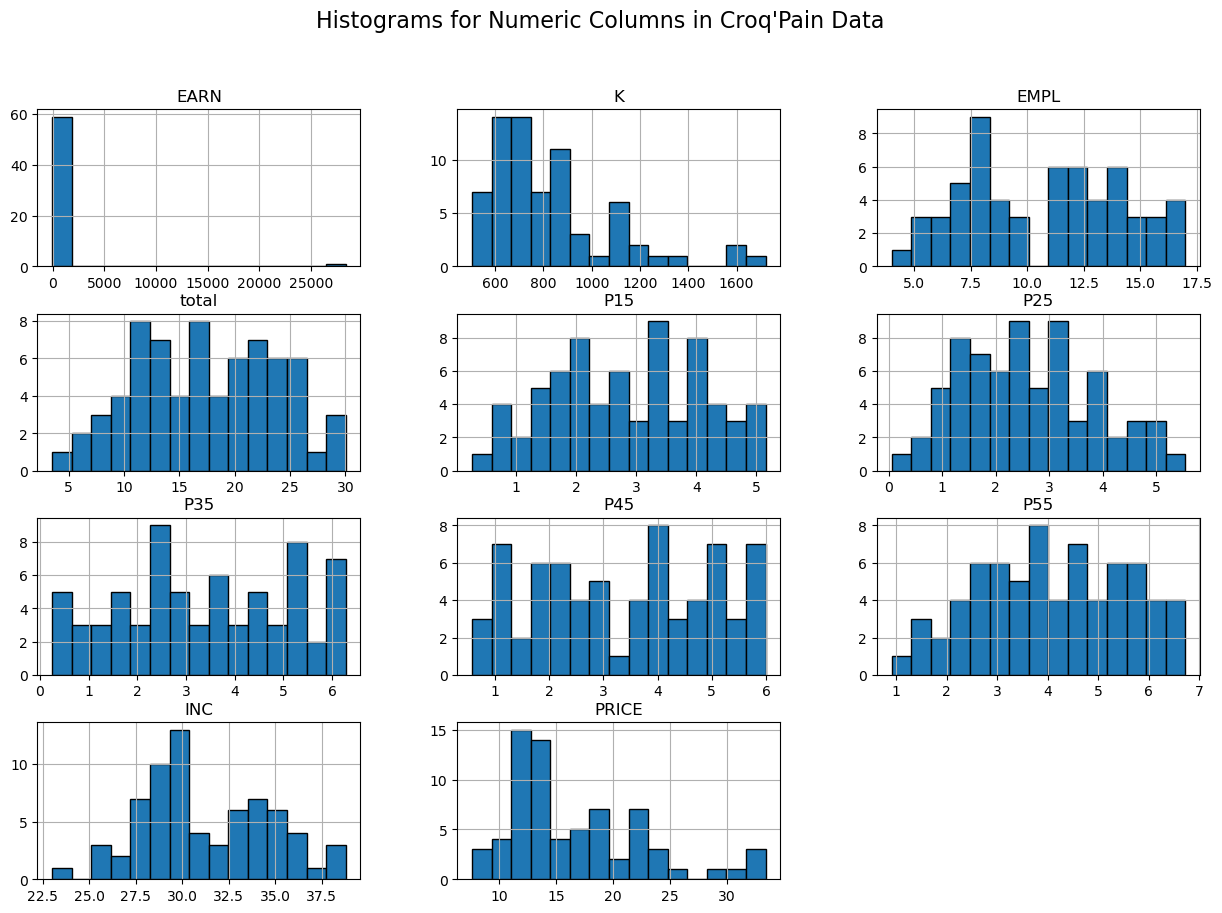

In [3]:
numeric_columns = croq_df.select_dtypes(include=['float64', 'int64']).columns

croq_df[numeric_columns].hist(figsize=(15, 10), bins=15, edgecolor='black')
plt.suptitle("Histograms for Numeric Columns in Croq'Pain Data", fontsize=16)
plt.show()

In [4]:
# Step 1: Handle Missing Values
# For EARN and EMPL: Fill missing values with median
croq_df['EARN'] = croq_df['EARN'].fillna(croq_df['EARN'].median())
croq_df['EMPL'] = croq_df['EMPL'].fillna(croq_df['EMPL'].median())

# Step 3: Address Outliers
# For EARN: Cap outliers at the 95th percentile
earn_cap = croq_df['EARN'].quantile(0.95)
croq_df['EARN'] = croq_df['EARN'].clip(upper=earn_cap)

# For other numeric columns with potential outliers, cap at 95th percentile
for col in ['total', 'P15', 'P25', 'P35', 'P45', 'P55']:
    cap = croq_df[col].quantile(0.95)
    croq_df[col] = croq_df[col].clip(upper=cap)

# Step 4: Final Validation
# Ensure no missing values remain
croq_df_cleaned = croq_df.fillna(0)

### Part (a)

Visualize the data: examine histograms and scatterplots. Look at correlations between variables and try to identify sources of concern. Pay particular attention to the correlation for `total` and `P15` through `P55`. Do these correlations make sense to you?

No plot will be created for CITY (type object)


/opt/conda/lib/python3.11/site-packages/pyrsm/model/model.py:803: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [pos - 0.5, pos + 0.5], [means[pos], means[pos]], color="blue"


Linear regression (OLS)
Data                 : croq_df_cleaned
Response variable    : EARN
Explanatory variables: STOR, K, SIZE, EMPL, total, P15, P25, P35, P45, P55, INC, COMP, NCOMP, NREST, PRICE, CLI, CITY
Null hyp.: the effect of x on EARN is zero
Alt. hyp.: the effect of x on EARN is not zero

                    coefficient  std.error  t.value p.value     
Intercept              -473.992    150.740   -3.144   0.003   **
CITY[Aubusson]          100.375     59.475    1.688   0.099    .
CITY[Calais]             80.458     61.656    1.305   0.199     
CITY[Clermont]           35.238     58.952    0.598   0.553     
CITY[Dijon]            -100.500     95.327   -1.054   0.298     
CITY[Marseilles-1]       34.368     64.506    0.533   0.597     
CITY[Marseilles-2]      162.757     61.074    2.665   0.011    *
CITY[Montchanin]         33.432     67.522    0.495   0.623     
CITY[Montpellier]       -39.099     75.610   -0.517   0.608     
CITY[Torcy]             164.197     81.866    2.00

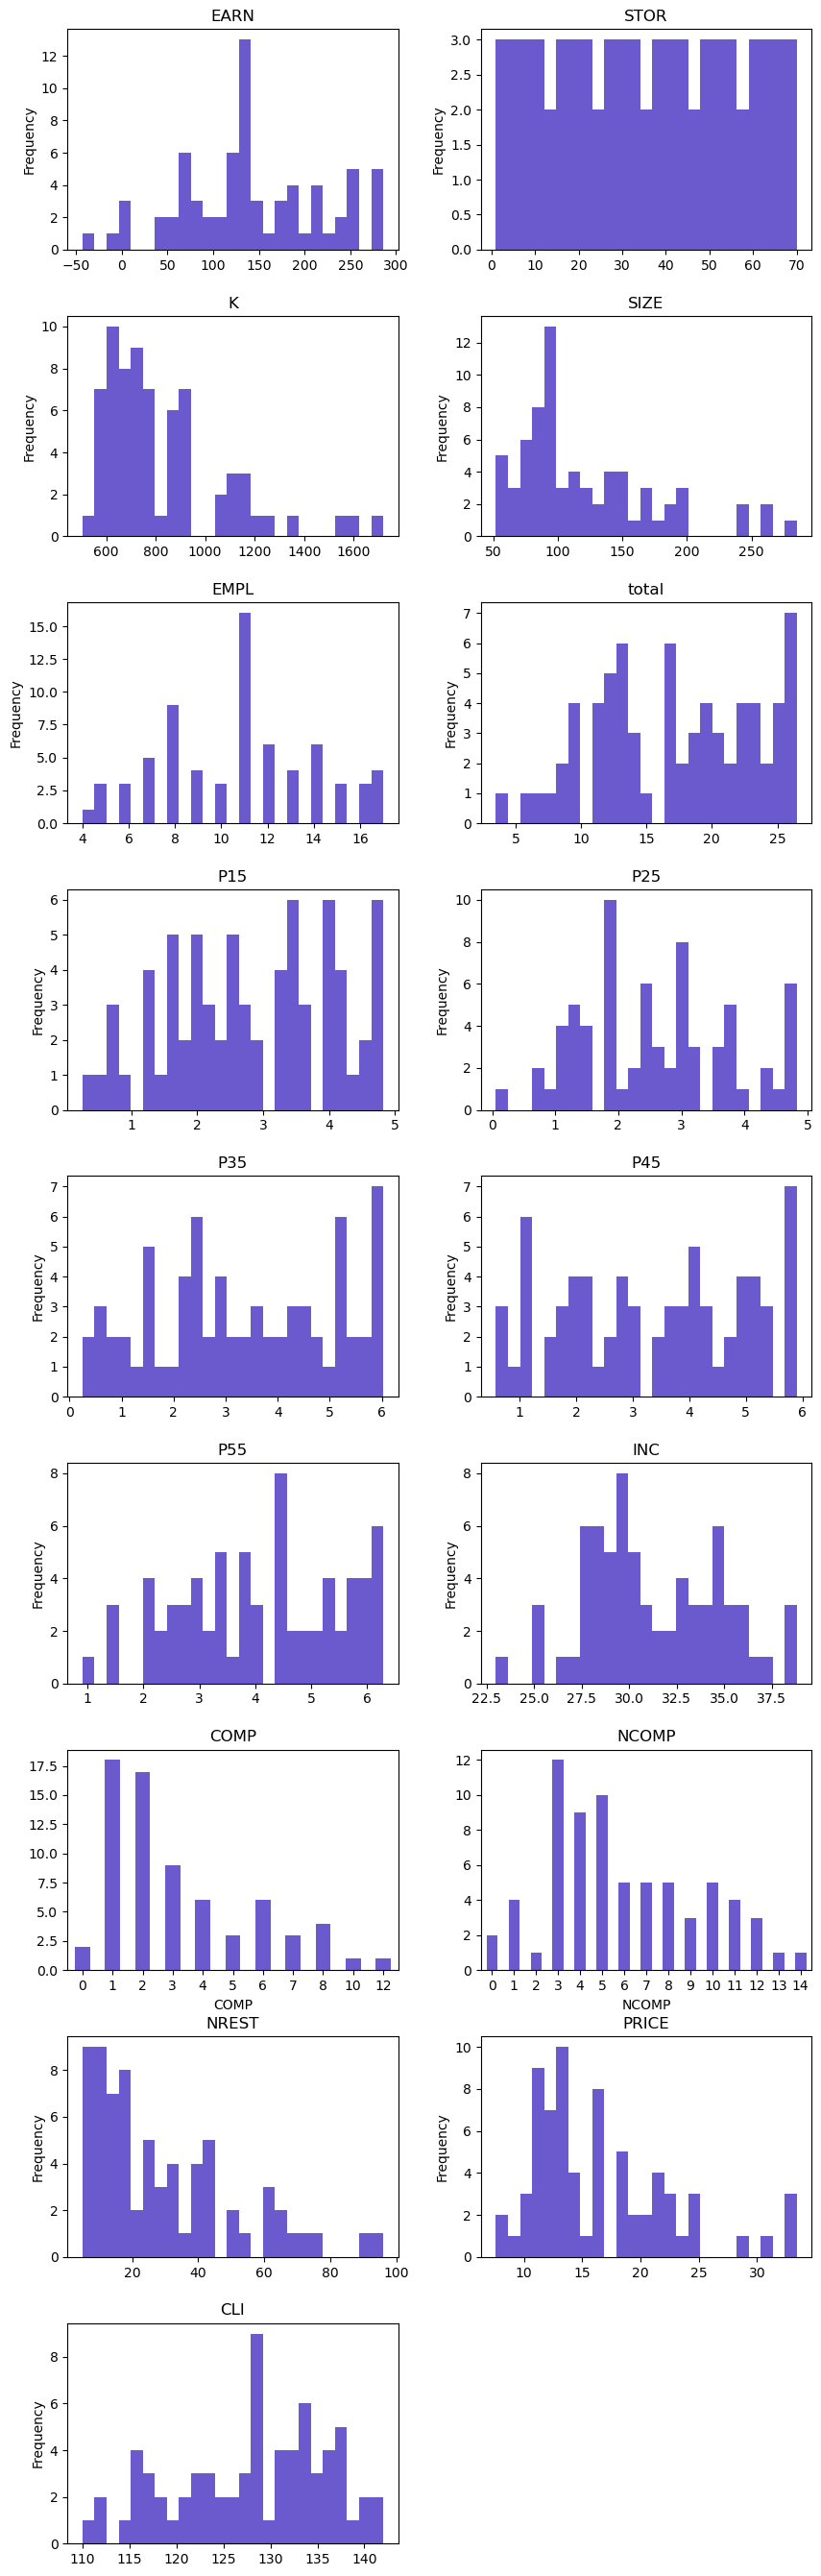

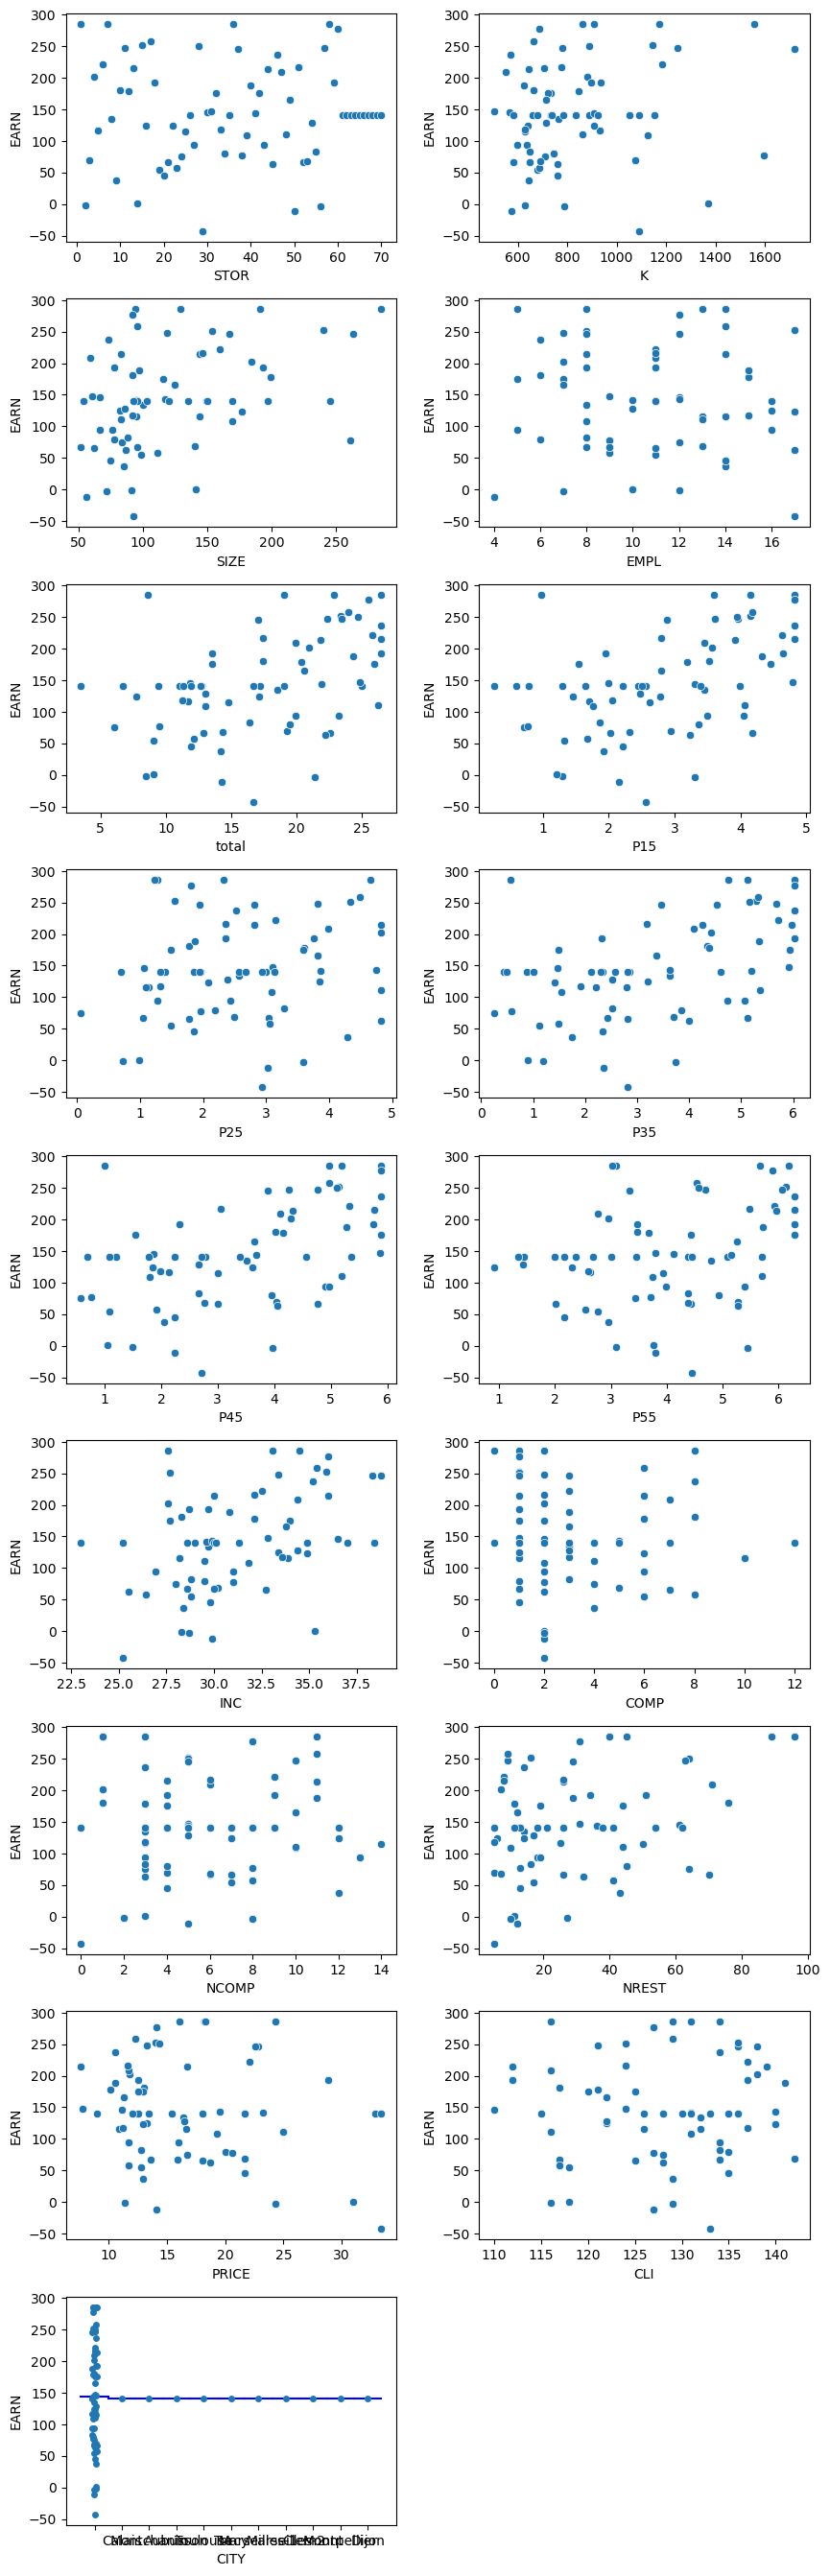

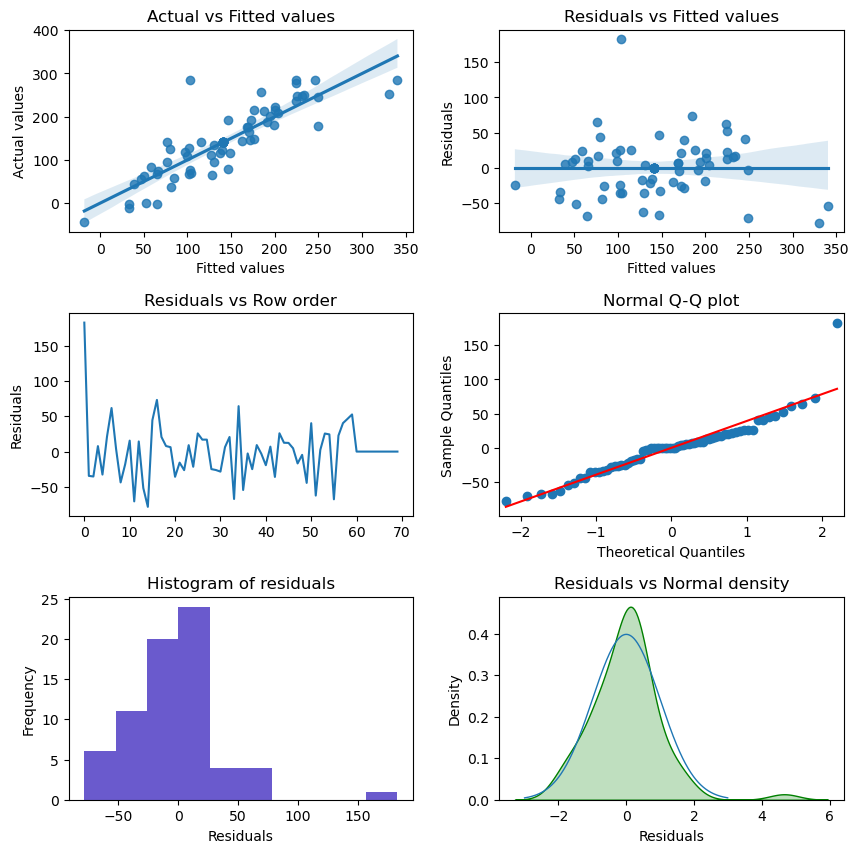

In [5]:
# Perform regression analysis using pyrsm
reg1 = rsm.regress({"croq_df_cleaned": croq_df_cleaned}, rvar="EARN", evar=["STOR", "K", "SIZE", "EMPL", "total", "P15", "P25", "P35", "P45", "P55", "INC", "COMP", "NCOMP", "NREST", "PRICE", "CLI", "CITY"])
reg1.plot("dist")
reg1.plot("scatter")
reg1.plot("dashboard")
reg1.summary(vif=True)

In [6]:
croq_df_cleaned[['total', 'P15', 'P25', 'P35', 'P45', 'P55']].corr()

,total,P15,P25,P35,P45,P55
total,1.000000,0.950530,0.579331,0.960985,0.953565,0.782865
P15,0.950530,1.000000,0.470842,0.966436,0.942246,0.675507
P25,0.579331,0.470842,1.000000,0.467446,0.429356,0.317564
P35,0.960985,0.966436,0.467446,1.000000,0.965044,0.682268
P45,0.953565,0.942246,0.429356,0.965044,1.000000,0.667027
P55,0.782865,0.675507,0.317564,0.682268,0.667027,1.000000


1.	Strong Correlations (P15, P35, P45):

•	The extremely high correlations for P15, P35, and P45 (0.95 and above) suggest that these variables are closely tied to total.

•	These values make sense if these variables represent sub-components or key contributors to total.

2.	Moderate Correlation (P25):

•	The correlation of P25 (0.58) is weaker but still positive and notable. It indicates that P25 has a different relationship with total compared to the other variables, potentially due to different characteristics of this population segment.

3.	Relatively Weaker Correlation (P55):

•	P55 has a lower correlation (0.78), which is still strong but lower than P15, P35, and P45. This might indicate that P55 has less influence on total or represents a less directly relevant variable.

Sources of Concern:

1.	Multicollinearity:

•	The high correlations between the P variables (e.g., P15, P35, P45) suggest significant multicollinearity.

•	This can pose challenges for regression analysis or other modeling approaches, as the variables might overlap in what they explain about total.

2.	Variance Inflation Factors (VIF):

•	The VIF results from regression analysis also confirm multicollinearity concerns, especially for P35, P45, and P15, which have extremely high VIF values.
	
3.	Potential Overfitting:

•	Given the very high R-squared (0.997) and adjusted R-squared (0.995), there’s a risk of overfitting. This can lead to poor generalization on new data.

Apply a transformation to the variables `EARN`, `P15`, `P25`, `P35`, `P45`, `P55`, `COMP`, `NCOMP`, and `NREST` where you normalize them by `total`. You can apply this normalization by defining new variables such as `EARN_total` which is equal to `EARN` divided by `total`.

Evaluate correlations and regressions with both the transformed and un-transformed data. Which do you prefer and why?

In [7]:
# Create a new DataFrame for transformed columns
transformed_columns = {
    "EARN_total": croq_df['EARN'] / croq_df['total'],
    "P15_total": croq_df['P15'] / croq_df['total'],
    "P25_total": croq_df['P25'] / croq_df['total'],
    "P35_total": croq_df['P35'] / croq_df['total'],
    "P45_total": croq_df['P45'] / croq_df['total'],
    "P55_total": croq_df['P55'] / croq_df['total'],
    "COMP_total": croq_df['COMP'] / croq_df['total'],
    "NCOMP_total": croq_df['NCOMP'] / croq_df['total'],
    "NREST_total": croq_df['NREST'] / croq_df['total'],
}

# Create a new DataFrame for transformed columns
# Create a new DataFrame with only the untransformed original columns plus the newly transformed columns
# Dropping the original columns that have been transformed (e.g., P15, P25, etc.)
columns_to_keep = croq_df.columns.difference(['P15', 'P25', 'P35', 'P45', 'P55', 'EARN', 'COMP', 'NCOMP', 'NREST'])
transformed_df = croq_df[columns_to_keep].copy()

# Add the transformed columns
transformed_df = pd.concat([transformed_df, pd.DataFrame(transformed_columns)], axis=1)

transformed_df.head()

,CITY,CLI,EMPL,INC,K,PRICE,SIZE,STOR,total,EARN_total,P15_total,P25_total,P35_total,P45_total,P55_total,COMP_total,NCOMP_total,NREST_total
0,,129,14.0,27.6,861.0718,16.1,129,1,8.58,33.329364,0.114219,0.149184,0.065268,0.116550,0.361305,0.932401,0.116550,5.244755
1,,116,12.0,28.3,630.3028,11.4,91,2,8.46,-0.171986,0.152482,0.085106,0.141844,0.176123,0.366430,0.236407,0.236407,3.191489
2,,142,13.0,30.2,1074.4360,21.7,140,3,19.25,3.580918,0.152727,0.129351,0.192727,0.209351,0.273766,0.259740,0.207792,0.259740
3,,138,7.0,27.6,882.0064,11.8,184,4,20.92,9.659337,0.170650,0.230736,0.211281,0.205545,0.141491,0.095602,0.047801,0.334608
4,,126,14.0,33.9,930.6688,16.6,144,5,11.66,9.929546,0.145798,0.097770,0.188679,0.183533,0.225557,0.085763,0.257290,2.144082


Linear regression (OLS)
Data                 : transformed_df
Response variable    : EARN_total
Explanatory variables: STOR, K, SIZE, EMPL, total, P15_total, P25_total, P35_total, P45_total, P55_total, INC, COMP_total, NCOMP_total, NREST_total, PRICE, CLI
Null hyp.: the effect of x on EARN_total is zero
Alt. hyp.: the effect of x on EARN_total is not zero

             coefficient  std.error  t.value p.value     
Intercept        -15.113     12.719   -1.188    0.24     
STOR               0.026      0.030    0.878   0.384     
K                  0.001      0.008    0.166   0.869     
SIZE               0.031      0.029    1.062   0.293     
EMPL              -0.002      0.173   -0.010   0.992     
total              0.025      0.168    0.151   0.881     
P15_total        -34.390     28.458   -1.208   0.232     
P25_total          2.857     13.771    0.207   0.836     
P35_total         -3.068     25.270   -0.121   0.904     
P45_total          7.215     22.132    0.326   0.746     
P55

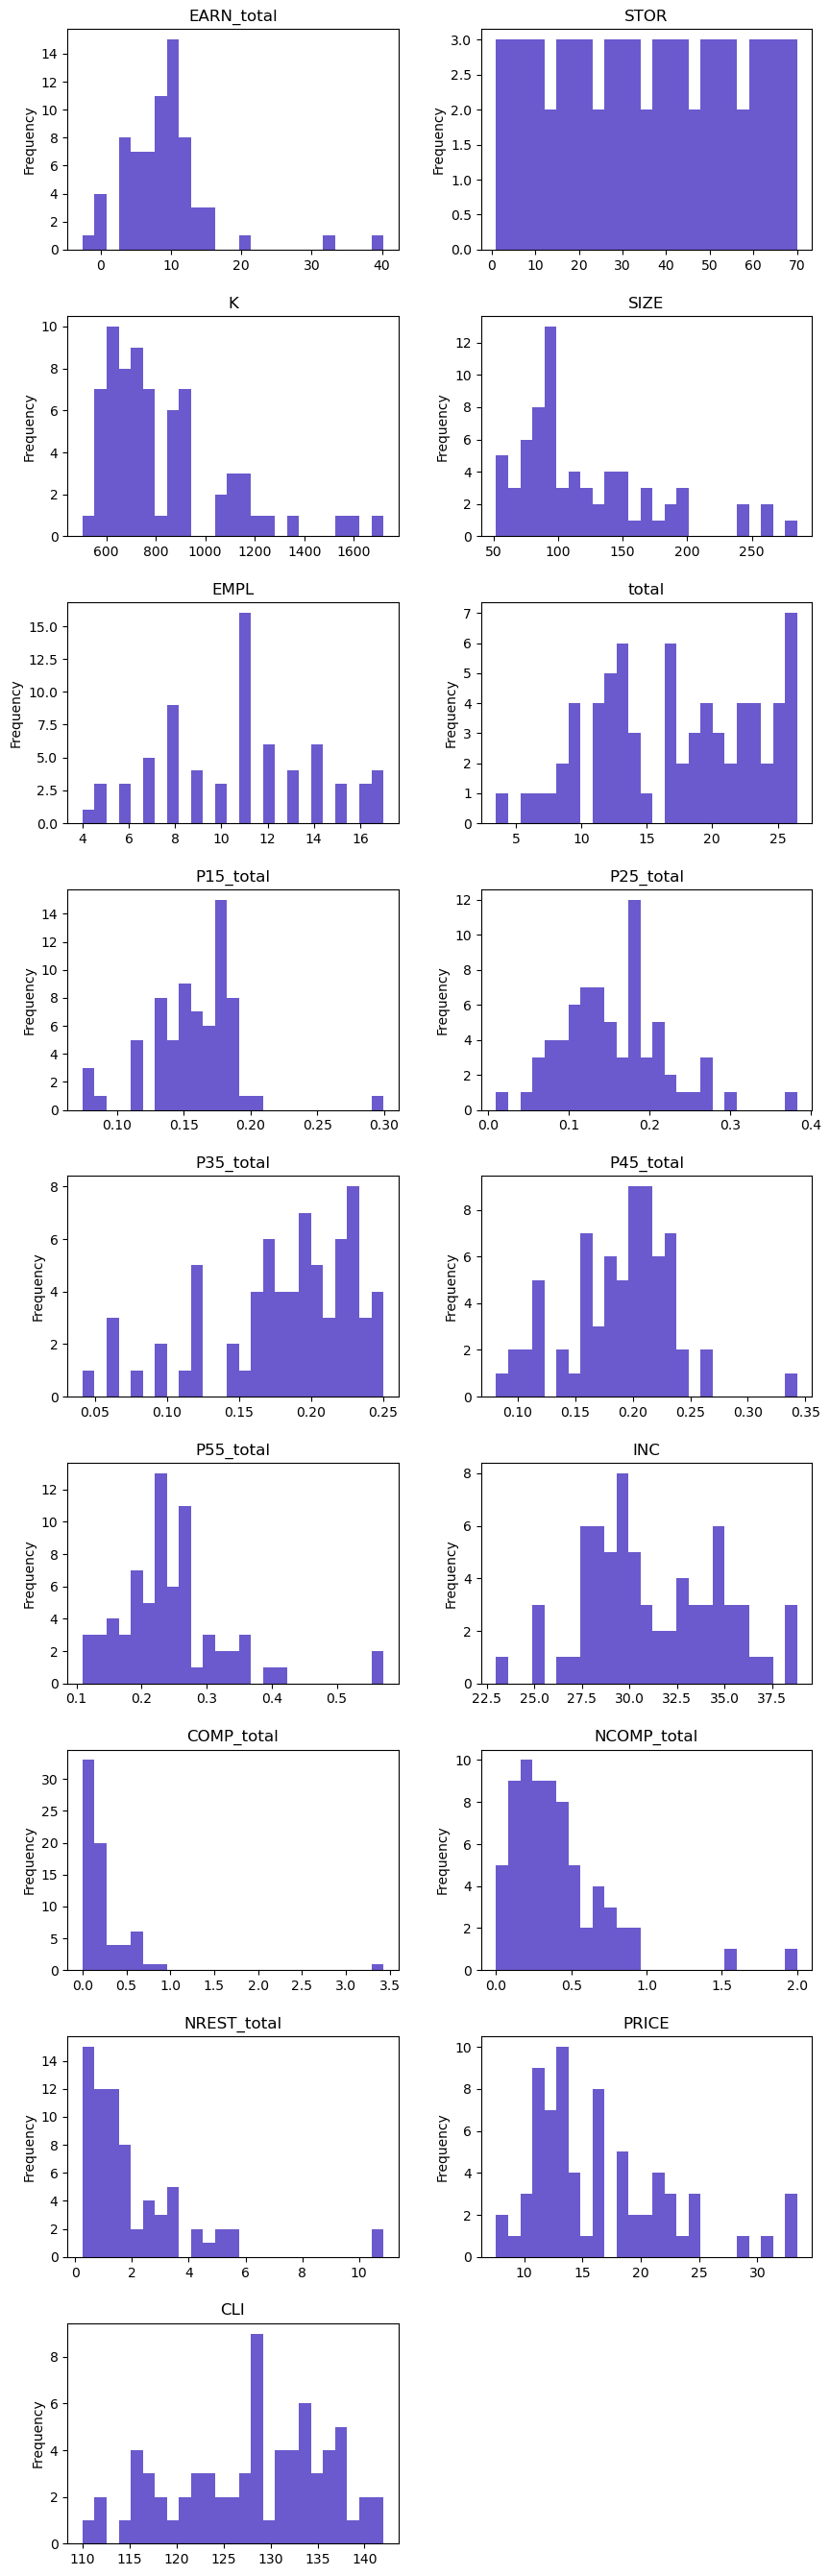

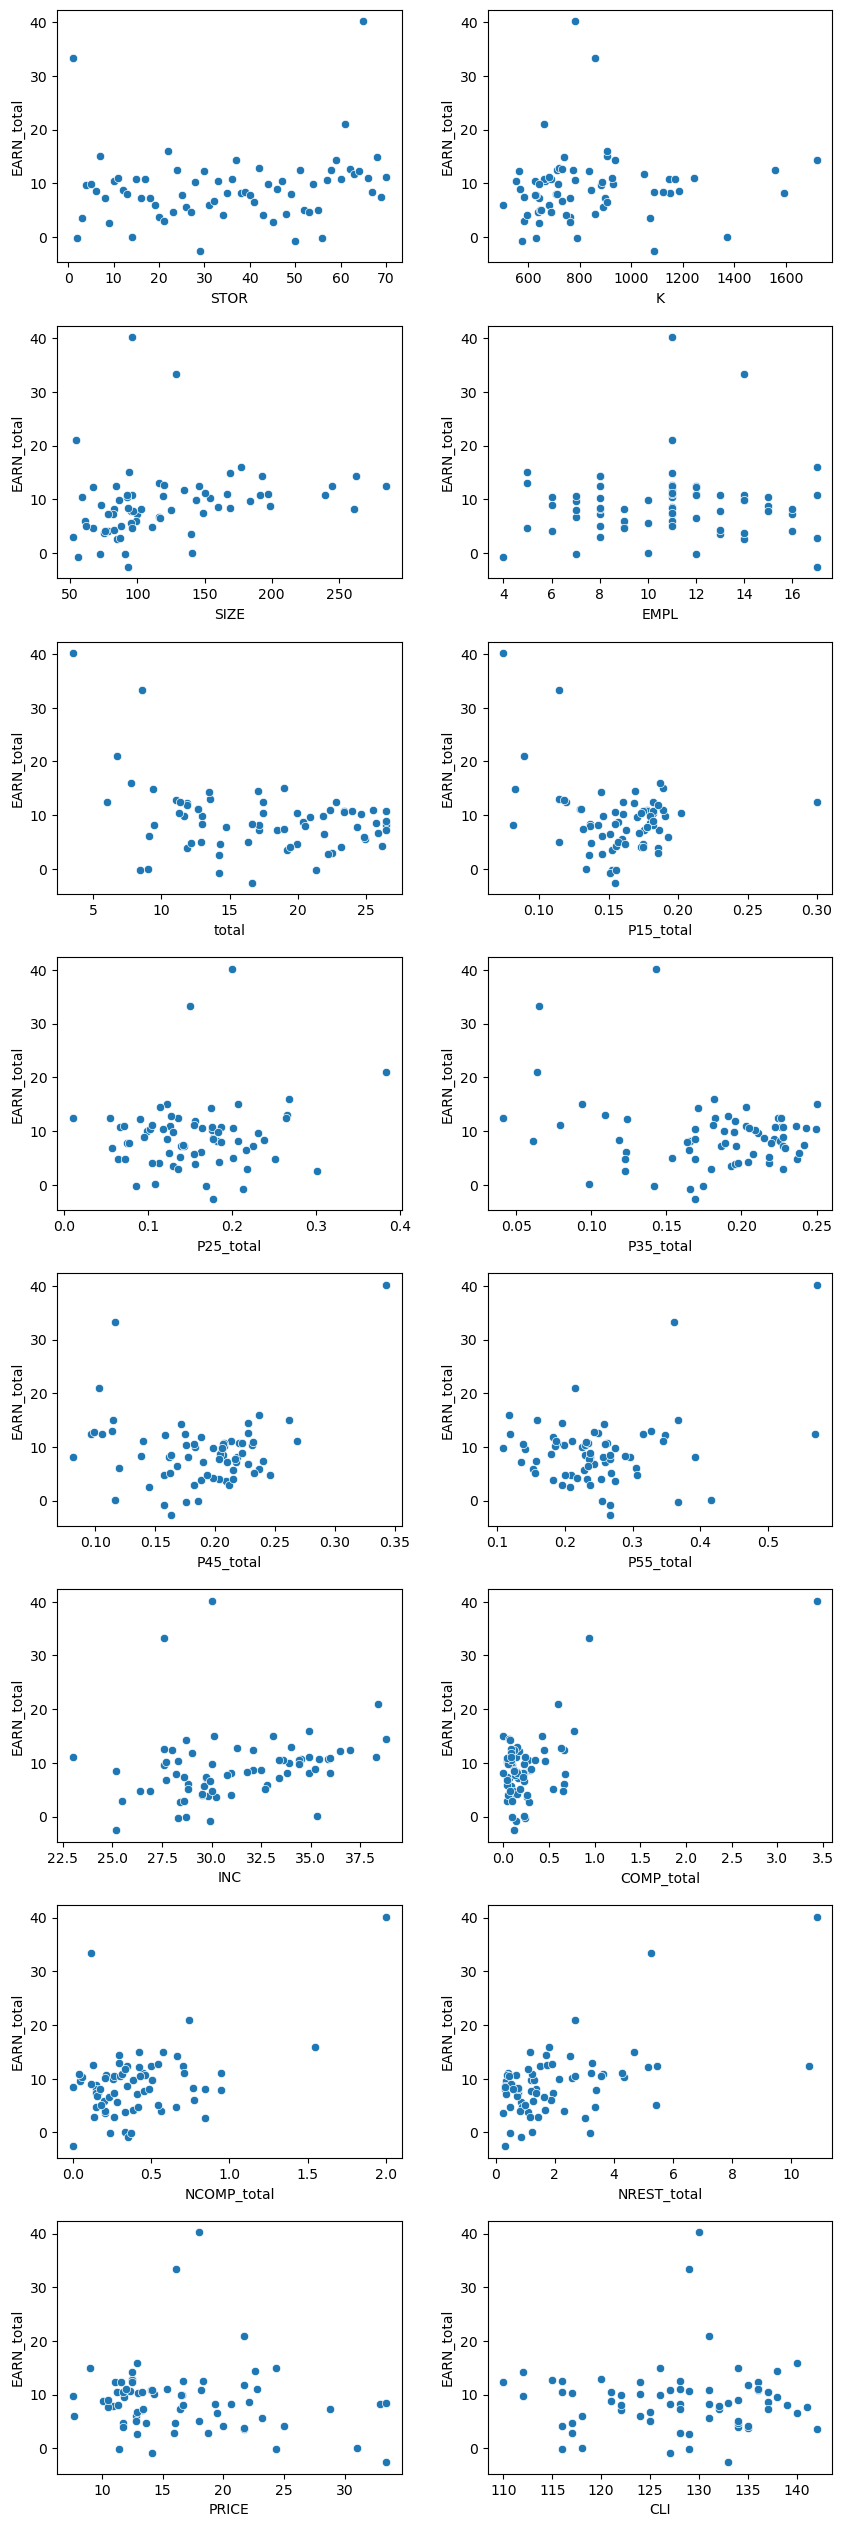

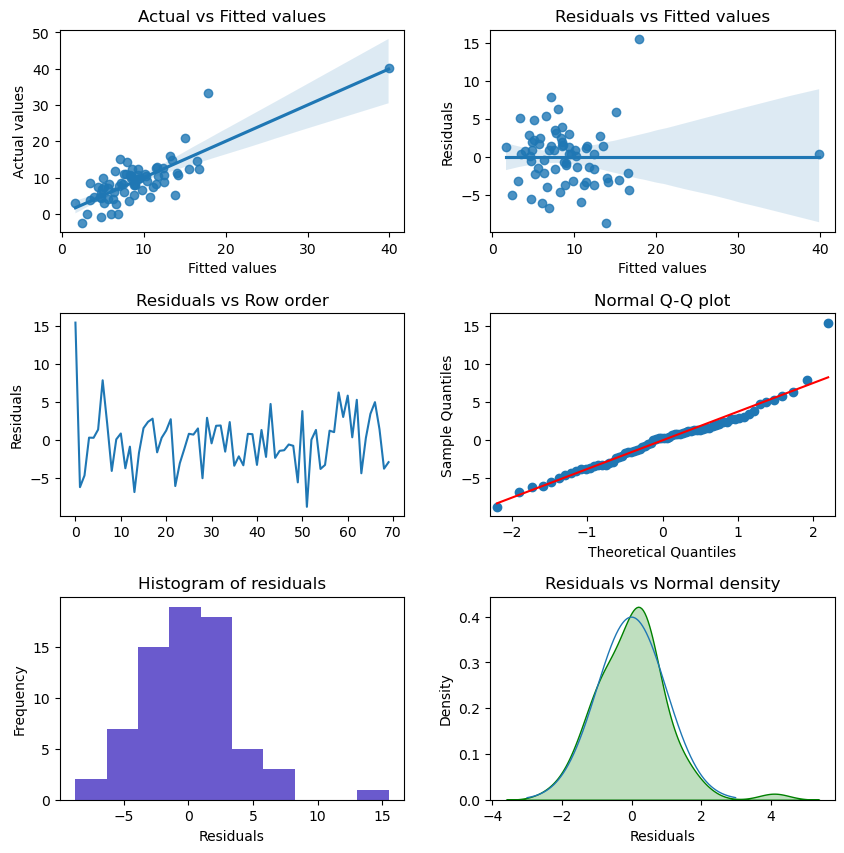

In [8]:
# Perform regression analysis using pyrsm
reg2 = rsm.regress({"transformed_df": transformed_df}, rvar="EARN_total", evar=["STOR", "K", "SIZE", "EMPL", "total", "P15_total", "P25_total", "P35_total", "P45_total", "P55_total", "INC", "COMP_total", "NCOMP_total", "NREST_total", "PRICE", "CLI"])
reg2.plot("dist")
reg2.plot("scatter")
reg2.plot("dashboard")
reg2.summary(vif=True)

In [9]:
untransformed_corr = croq_df_cleaned[['total', 'EARN', 'P15', 'P25', 'P35', 'P45', 'P55', 'COMP', 'NCOMP', 'NREST']].corr()
transformed_corr = transformed_df[['total', 'EARN_total', 'P15_total', 'P25_total', 'P35_total', 'P45_total', 'P55_total', 'COMP_total', 'NCOMP_total', 'NREST_total']].corr()

In [10]:
untransformed_corr

,total,EARN,P15,P25,P35,P45,P55,COMP,NCOMP,NREST
total,1.000000,0.445400,0.950530,0.579331,0.960985,0.953565,0.782865,-0.252748,0.055010,0.026855
EARN,0.445400,1.000000,0.476073,0.160723,0.493547,0.484591,0.305087,-0.015345,0.074687,0.304225
P15,0.950530,0.476073,1.000000,0.470842,0.966436,0.942246,0.675507,-0.219628,0.054627,0.085811
P25,0.579331,0.160723,0.470842,1.000000,0.467446,0.429356,0.317564,-0.103969,0.061779,0.004904
P35,0.960985,0.493547,0.966436,0.467446,1.000000,0.965044,0.682268,-0.199261,0.036682,0.084491
P45,0.953565,0.484591,0.942246,0.429356,0.965044,1.000000,0.667027,-0.200400,0.071901,0.084830
P55,0.782865,0.305087,0.675507,0.317564,0.682268,0.667027,1.000000,-0.275416,-0.021657,-0.050912
COMP,-0.252748,-0.015345,-0.219628,-0.103969,-0.199261,-0.200400,-0.275416,1.000000,0.153203,0.115929
NCOMP,0.055010,0.074687,0.054627,0.061779,0.036682,0.071901,-0.021657,0.153203,1.000000,0.099718
NREST,0.026855,0.304225,0.085811,0.004904,0.084491,0.084830,-0.050912,0.115929,0.099718,1.000000


In [11]:
transformed_corr

,total,EARN_total,P15_total,P25_total,P35_total,P45_total,P55_total,COMP_total,NCOMP_total,NREST_total
total,1.000000,-0.345211,0.440721,-0.235847,0.722601,0.450648,-0.421160,-0.500308,-0.535717,-0.488411
EARN_total,-0.345211,1.000000,-0.258699,0.125379,-0.214863,0.122311,0.285539,0.662931,0.453490,0.556745
P15_total,0.440721,-0.258699,1.000000,-0.240698,0.699698,0.313562,-0.595918,-0.367626,-0.278468,-0.196698
P25_total,-0.235847,0.125379,-0.240698,1.000000,-0.292458,-0.322553,-0.218512,0.161876,0.285098,-0.044184
P35_total,0.722601,-0.214863,0.699698,-0.292458,1.000000,0.626470,-0.601914,-0.290076,-0.338169,-0.334012
P45_total,0.450648,0.122311,0.313562,-0.322553,0.626470,1.000000,-0.312717,0.182052,0.089489,0.019873
P55_total,-0.421160,0.285539,-0.595918,-0.218512,-0.601914,-0.312717,1.000000,0.459904,0.241218,0.459772
COMP_total,-0.500308,0.662931,-0.367626,0.161876,-0.290076,0.182052,0.459904,1.000000,0.685364,0.649197
NCOMP_total,-0.535717,0.453490,-0.278468,0.285098,-0.338169,0.089489,0.241218,0.685364,1.000000,0.480224
NREST_total,-0.488411,0.556745,-0.196698,-0.044184,-0.334012,0.019873,0.459772,0.649197,0.480224,1.000000


Before Normalization:

1.	Histograms and Scatterplots:

•	The total variable is strongly correlated with P15, P35, and P45 in the scatterplots. These three variables dominate the relationship with total.

•	Histograms show some skewness and concentration in variables like EARN, P55, and others, indicating scaling effects that might overshadow smaller contributors.

2.	Regression Results:

•	High R-squared (0.997): The model captures almost all variance in total, which is unrealistic and suggests overfitting.

•	Significant Predictors: P15, P25, P35, P45, and P55 dominate the model, but multicollinearity is evident from high VIF values (e.g., for P15, P35, P45).

•	Residual Plots: Residuals appear well-distributed, but the extremely high fit may mean these residuals will worsen on new data.

After Normalization:

1.	Histograms and Scatterplots:

•	The normalization by total shifted the scales of variables like P15_total, P35_total, and COMP_total, with their distributions becoming more centered and interpretable as relative proportions.

•	Scatterplots show weaker linear relationships compared to the un-transformed data, especially for previously dominating variables like P15.

2.	Regression Results:

•	R-squared (0.781): Lower R-squared indicates a better generalization capacity, though it explains less variance compared to the un-transformed model.
	
•	Key Predictors: Significant predictors included P25_total, P35_total, and P55_total, showing clearer, proportional contributions to total.

•	Residual Plots: Residuals still appear well-distributed but are more substantial compared to the pre-normalization case, reflecting the less aggressive model fit.

3.	Multicollinearity:

•	While still present, multicollinearity is reduced for some variables after normalization, leading to more stable estimates.

Preference and Why:

Based on a direct comparison of your results:

1.	Model Stability:

•	The normalized model has a lower R-squared but avoids the pitfalls of overfitting seen in the un-transformed model. This suggests it will generalize better to new data.

2.	Interpretability:

•	Normalized variables (e.g., P15_total, P25_total) allow for a proportional understanding of contributions to total. For example, P35_total being significant highlights its importance relative to total, rather than being influenced by scale.

3.	Realistic Fit:

•	While the un-transformed model may look better in terms of R-squared, the extremely high values (0.997) are not realistic and indicate the model is likely overfitting to noise or redundant information.

4.	Multicollinearity:

•	Although some variables still exhibit high VIFs in the normalized model, the situation is improved compared to the un-transformed model, making the regression coefficients more reliable.

Final Recommendation:

***The normalized model is preferred*** because it reduces overfitting, provides proportional insights, and is more likely to generalize well to unseen data. 

When you run regressions, be sure to use the `VIF` feature in Radiant for a more rigorous evaluation of multicollinearity. As you are building a model, it can also be useful to examine standardized coefficients. Also, conduct linear regression validation checks by using the `dashboard` plots in the `Plots` tab (see section 6.6 in the book).

If interested, you can experiment with the `Stepwise selection` option in the _Summary_ tab (i.e., click the checkbox) in the R version of Radiant (launched from RStudio). This is a feature in Radiant that uses a purely statistical approach to model building based on the Akaike Information Criterion (AIC). It will go through a series of steps and recommend a final model (see the bottom of the output). Compare the model selected using `Stepwise selection` to the model you arrived at yourself. Be critical and make a decision about the final model to recommend for Croq`Pain.

In [12]:
# radiant
rsm.radiant.regress(
    {"croq": croq_df_cleaned},
    {"croq": croq_desc},
    code = True,
)

Listening on http://0.0.0.0:8000
Pyrsm and Radiant are open source tools and free to use. If you
are a student or instructor using pyrsm or Radiant for a class,
as a favor to the developers, please send an email to
<radiant@rady.ucsd.edu> with the name of the school and class.
If you are using Radiant in your company, as a favor to the
developer, please share the name of your company and what types
of activites you are supporting with the tool.


In [13]:
# radiant
rsm.radiant.regress(
    {"croq": transformed_df},
    {"croq": croq_desc},
    code = True,
)

Listening on http://0.0.0.0:8000
Pyrsm and Radiant are open source tools and free to use. If you
are a student or instructor using pyrsm or Radiant for a class,
as a favor to the developers, please send an email to
<radiant@rady.ucsd.edu> with the name of the school and class.
If you are using Radiant in your company, as a favor to the
developer, please share the name of your company and what types
of activites you are supporting with the tool.


### Part (b)

Remember to use a subset of the `CroqPainFix` data with only the 50 stores opened up prior to 1994. After you build your regression model using `CroqPainFix` select the `Predict` tab in Radiant.

In [14]:
# Filter the dataset to include only the first 50 stores (opened prior to 1994)
croqpainfix = transformed_df.iloc[:50]

In [15]:
# radiant
rsm.radiant.regress(
    {"croq": croqpainfix},
    {"croq": croq_desc},
    code = True,
)

Listening on http://0.0.0.0:8000
Pyrsm and Radiant are open source tools and free to use. If you
are a student or instructor using pyrsm or Radiant for a class,
as a favor to the developers, please send an email to
<radiant@rady.ucsd.edu> with the name of the school and class.
If you are using Radiant in your company, as a favor to the
developer, please share the name of your company and what types
of activites you are supporting with the tool.


No plot will be created for CITY (type object)


Task exception was never retrieved
future: <Task finished name='Task-14' coro=<Server.serve() done, defined at /opt/conda/lib/python3.11/site-packages/uvicorn/server.py:67> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/uvicorn/main.py", line 577, in run
    server.run()
  File "/opt/conda/lib/python3.11/site-packages/uvicorn/server.py", line 65, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/opt/conda/lib/python3.11/site-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.11/asyncio/events.py", line 84, in _run
    self._con

Linear regression (OLS)
Data                 : croqpainfix
Response variable    : EARN_total
Explanatory variables: STOR, K, SIZE, EMPL, total, P15_total, P25_total, P35_total, P45_total, P55_total, INC, COMP_total, NCOMP_total, NREST_total, PRICE, CLI, CITY
Null hyp.: the effect of x on EARN_total is zero
Alt. hyp.: the effect of x on EARN_total is not zero

             coefficient  std.error  t.value p.value     
Intercept          2.415     17.675    0.137   0.892     
STOR              -0.011      0.045   -0.234   0.817     
K                 -0.027      0.013   -2.108   0.043    *
SIZE               0.130      0.049    2.650   0.012    *
EMPL              -0.189      0.170   -1.114   0.273     
total              0.387      0.205    1.886   0.068    .
P15_total         -0.950     60.027   -0.016   0.987     
P25_total        -36.857     20.151   -1.829   0.076    .
P35_total       -125.609     63.436   -1.980   0.056    .
P45_total         13.648     56.266    0.243    0.81     


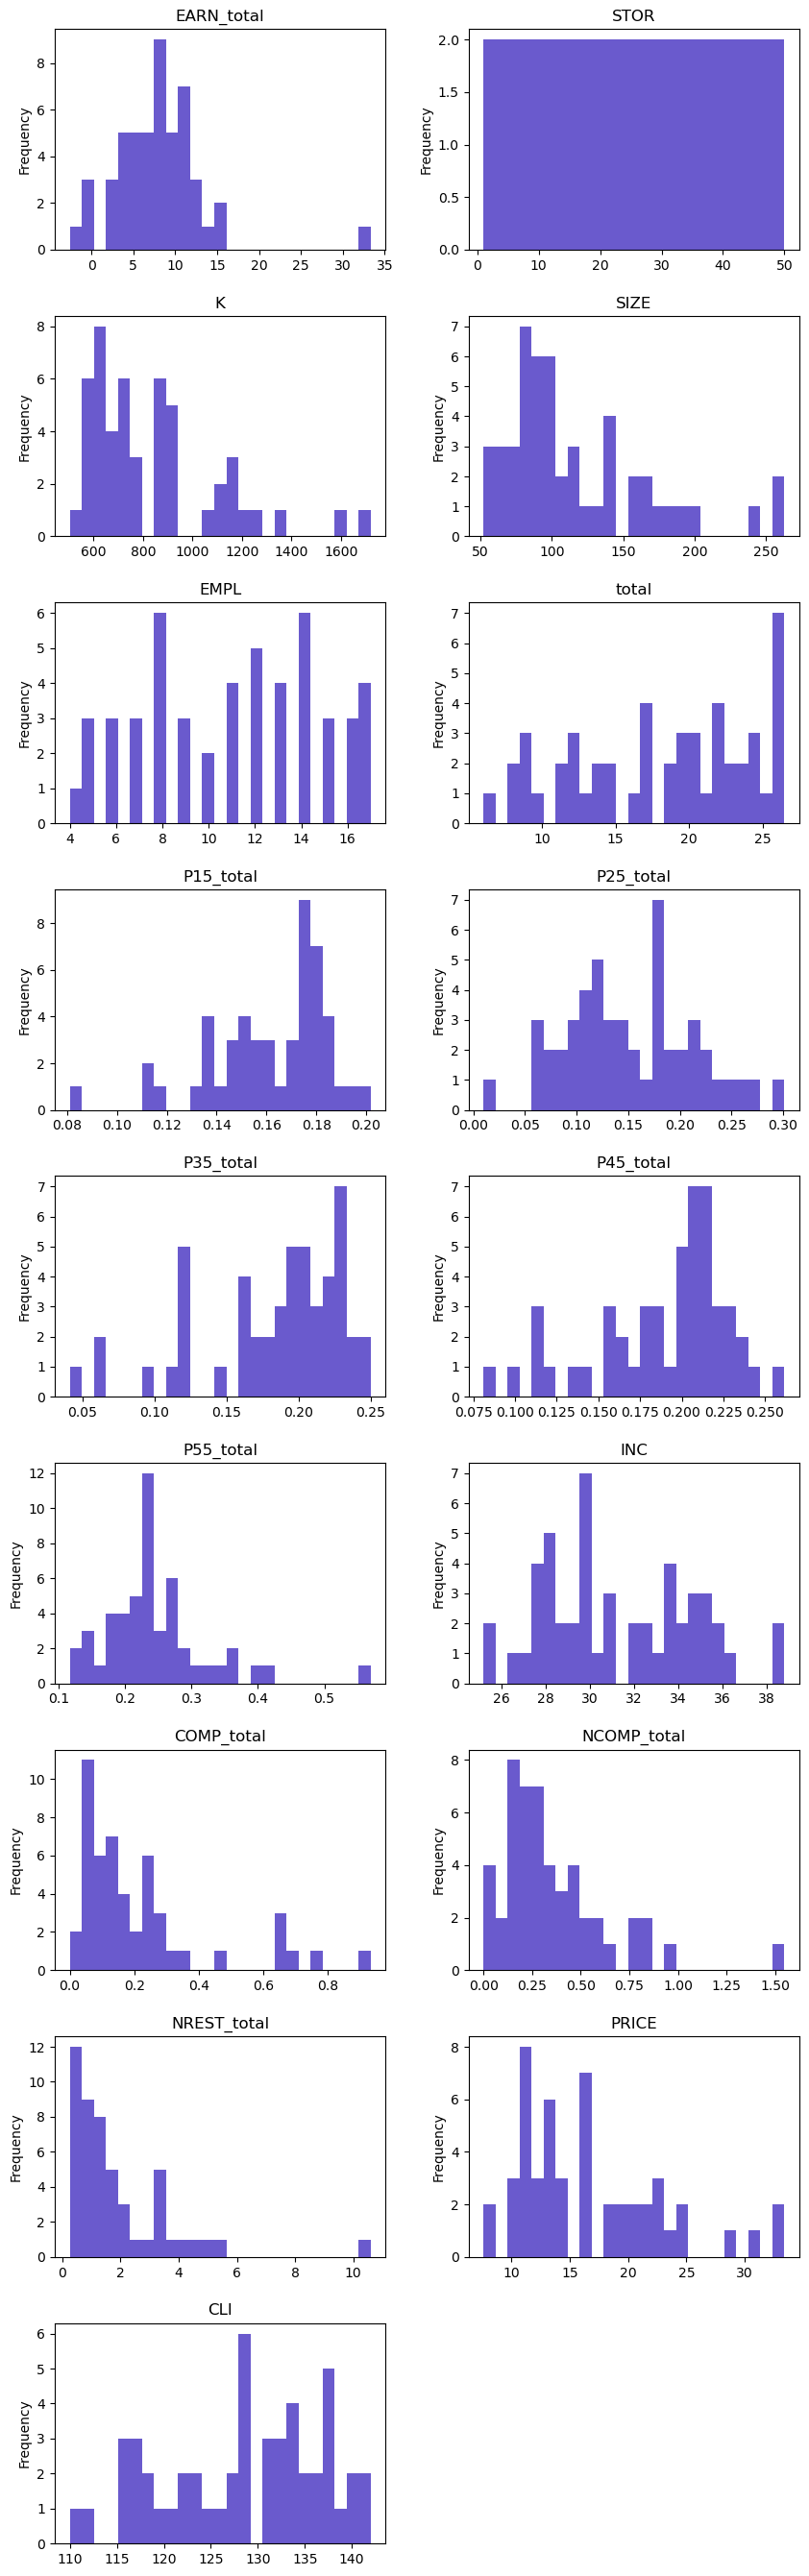

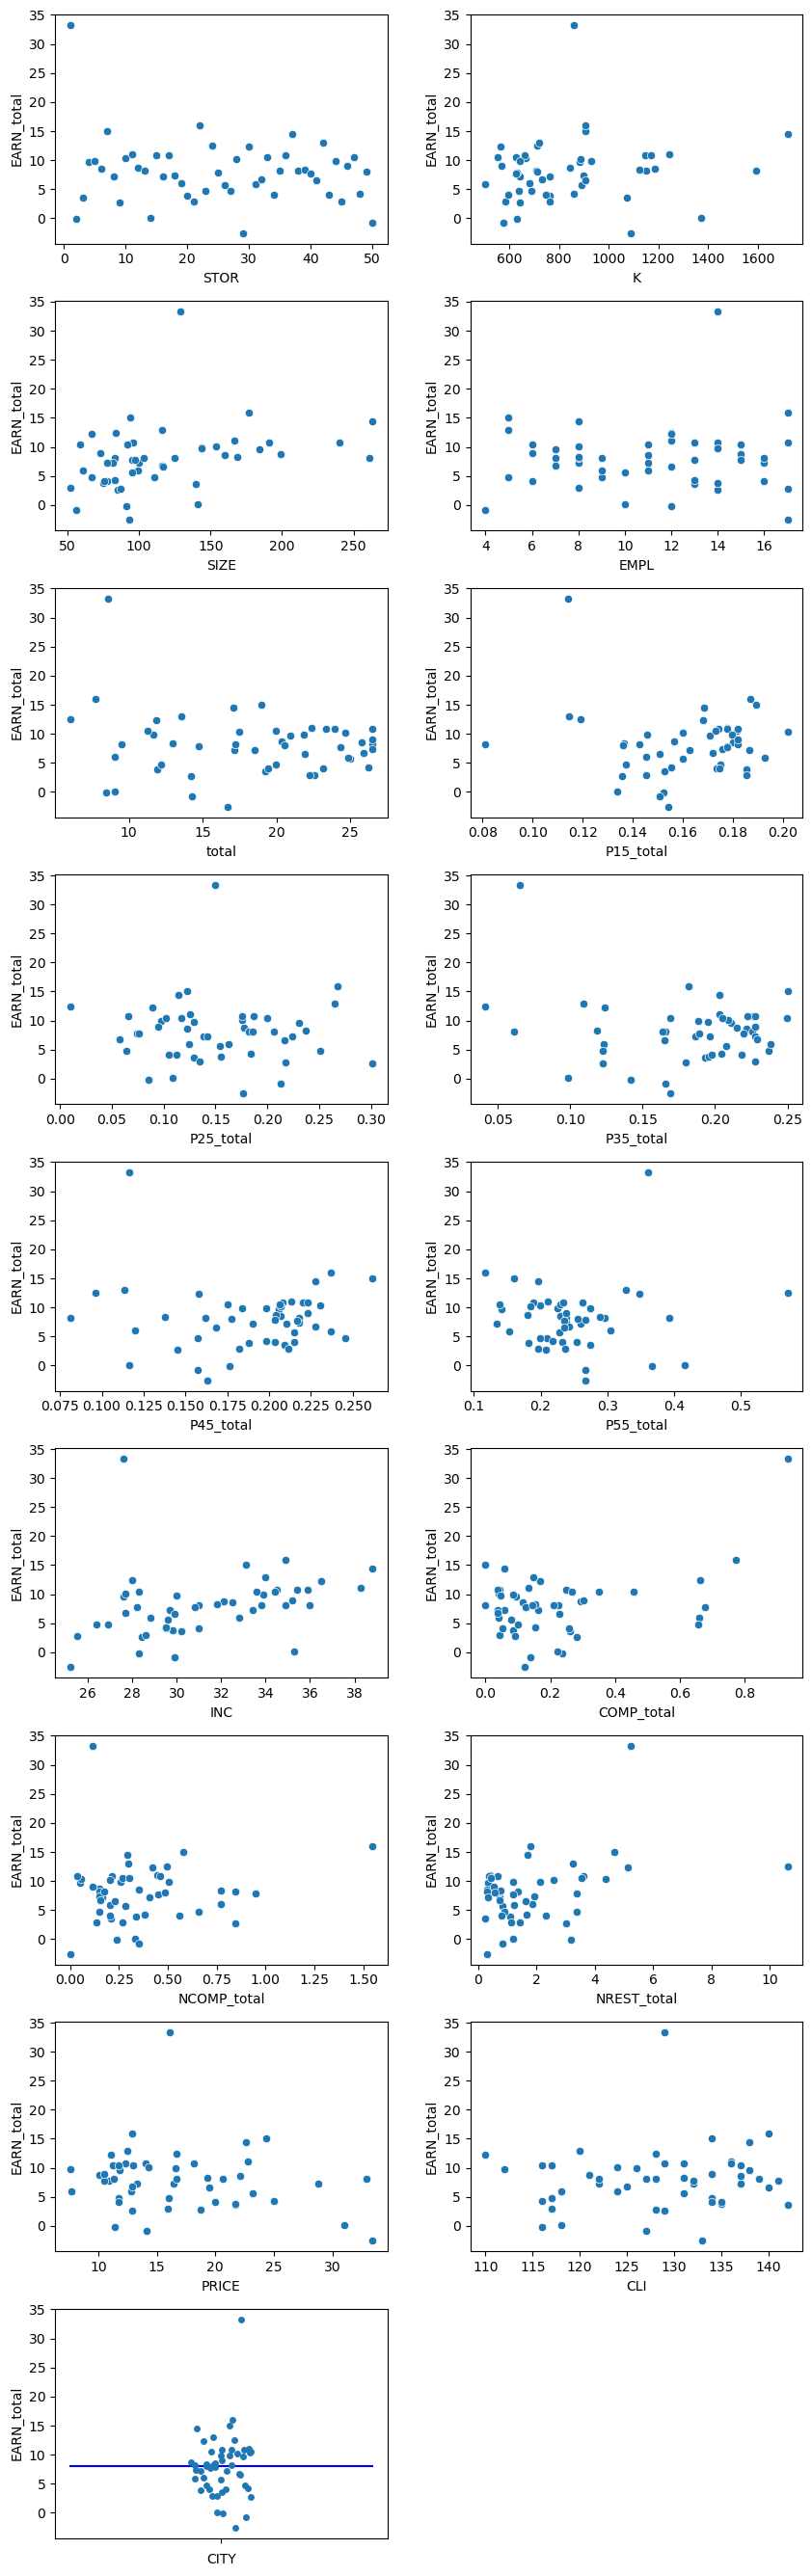

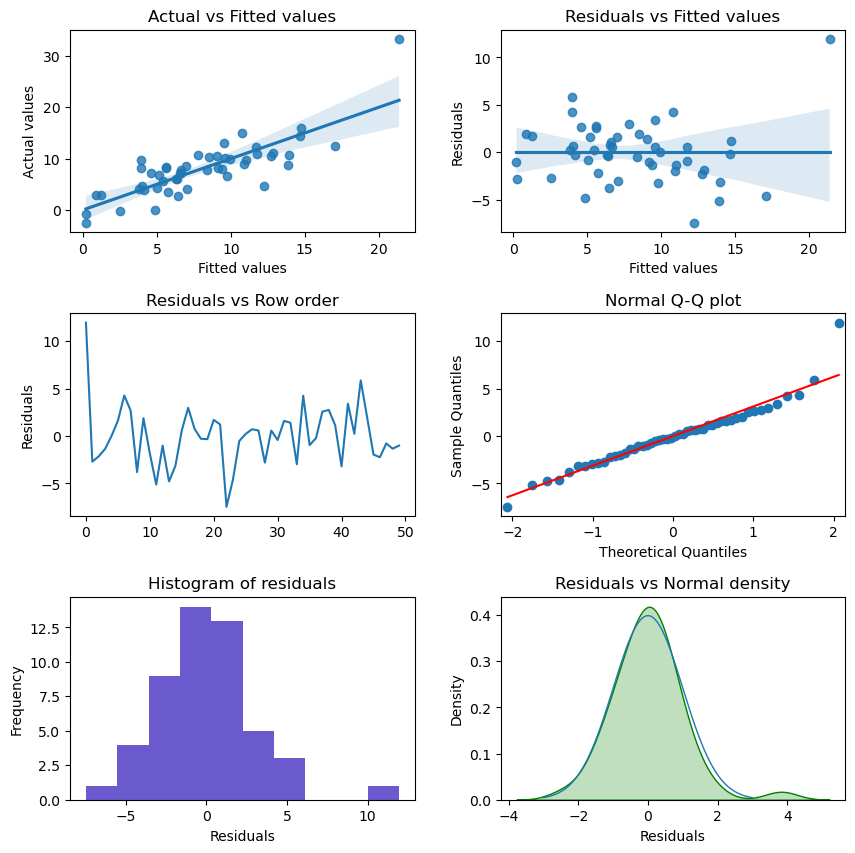

In [ ]:
# Perform regression analysis using pyrsm
reg3 = rsm.regress({"croqpainfix": croqpainfix}, rvar="EARN_total", evar=["STOR", "K", "SIZE", "EMPL", "total", "P15_total", "P25_total", "P35_total", "P45_total", "P55_total", "INC", "COMP_total", "NCOMP_total", "NREST_total", "PRICE", "CLI", "CITY"])
reg3.plot("dist")
reg3.plot("scatter")
reg3.plot("dashboard")
reg3.summary(vif=True)

### Part (c)

Croq'Pain's strategic planning group has developed a list of ten potential store locations for 1996 shown in Table 6.28. Which of these locations would you se-lect, i.e., which locations meet or exceed the performance ratio? Use the most complete model (60 restaurants) for your analysis.

In [16]:
pred = reg2.predict(data = transformed_df)
display(pred)

,STOR,K,SIZE,EMPL,total,P15_total,P25_total,P35_total,P45_total,P55_total,INC,COMP_total,NCOMP_total,NREST_total,PRICE,CLI,prediction
0,1,861.0718,129,14.0,8.58,0.114219,0.149184,0.065268,0.116550,0.361305,27.6,0.932401,0.116550,5.244755,16.1,129,17.836297
1,2,630.3028,91,12.0,8.46,0.152482,0.085106,0.141844,0.176123,0.366430,28.3,0.236407,0.236407,3.191489,11.4,116,5.995163
2,3,1074.4360,140,13.0,19.25,0.152727,0.129351,0.192727,0.209351,0.273766,30.2,0.259740,0.207792,0.259740,21.7,142,8.206143
3,4,882.0064,184,7.0,20.92,0.170650,0.230736,0.211281,0.205545,0.141491,27.6,0.095602,0.047801,0.334608,11.8,138,9.306574
4,5,930.6688,144,14.0,11.66,0.145798,0.097770,0.188679,0.183533,0.225557,33.9,0.085763,0.257290,2.144082,16.6,126,9.596016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,924.8080,197,11.0,12.72,0.129717,0.154088,0.180818,0.139937,0.345126,23.0,0.078616,0.707547,3.223270,12.0,136,7.581321
66,67,1089.5764,93,11.0,16.66,0.154262,0.176471,0.169268,0.163265,0.267107,25.2,0.120048,0.000000,0.300120,33.4,133,3.421778
67,68,737.6620,169,11.0,9.41,0.082891,0.206164,0.093518,0.114772,0.366631,30.1,0.425080,0.425080,1.168969,9.0,126,13.491514
68,69,584.0000,149,11.0,19.02,0.131441,0.140904,0.241851,0.240116,0.157729,28.6,0.210305,0.262881,1.366982,13.4,128,11.132470


In [17]:
np.median(pred['prediction'])

8.48868862288802

•	Locations with performance above the median (better than at least half the options).

•	Locations below the median (worse than at least half the options).

•	This is a fair and objective way to identify above-average locations without requiring an arbitrary cutoff.

Calais, Montchanin, Toulouse, Torcy and Clermont exceed the performance ratio, so I will choose these locations.

In [18]:
pred.corr()

,STOR,K,SIZE,EMPL,total,P15_total,P25_total,P35_total,P45_total,P55_total,INC,COMP_total,NCOMP_total,NREST_total,PRICE,CLI,prediction
STOR,1.000000,-0.090986,0.066666,-0.150482,-0.122066,-0.192044,0.140604,-0.072970,-0.053707,0.050580,-0.015825,0.117779,0.229966,0.095783,-0.070410,-0.117594,0.204431
K,-0.090986,1.000000,0.725028,0.037192,0.007973,-0.063639,-0.036138,-0.065734,-0.097952,0.136382,0.114064,-0.130348,-0.069328,-0.145943,0.582139,0.201289,0.103954
SIZE,0.066666,0.725028,1.000000,0.051691,-0.046592,0.037159,0.000203,-0.008141,-0.101862,0.014647,0.123599,-0.084968,0.084838,-0.053860,-0.037055,0.085600,0.297331
EMPL,-0.150482,0.037192,0.051691,1.000000,-0.098084,0.005973,0.038369,-0.090097,-0.034742,-0.007397,0.076144,0.093236,0.123595,-0.030438,0.069525,0.135041,0.051089
total,-0.122066,0.007973,-0.046592,-0.098084,1.000000,0.440721,-0.235847,0.722601,0.450648,-0.421160,0.036083,-0.500308,-0.535717,-0.488411,0.028569,0.136640,-0.427015
P15_total,-0.192044,-0.063639,0.037159,0.005973,0.440721,1.000000,-0.240698,0.699698,0.313562,-0.595918,0.212050,-0.367626,-0.278468,-0.196698,-0.081653,0.176232,-0.320003
P25_total,0.140604,-0.036138,0.000203,0.038369,-0.235847,-0.240698,1.000000,-0.292458,-0.322553,-0.218512,0.093725,0.161876,0.285098,-0.044184,0.054823,0.034331,0.155090
P35_total,-0.072970,-0.065734,-0.008141,-0.090097,0.722601,0.699698,-0.292458,1.000000,0.626470,-0.601914,0.055716,-0.290076,-0.338169,-0.334012,-0.074420,0.157020,-0.265779
P45_total,-0.053707,-0.097952,-0.101862,-0.034742,0.450648,0.313562,-0.322553,0.626470,1.000000,-0.312717,0.081101,0.182052,0.089489,0.019873,-0.034475,0.188243,0.151295
P55_total,0.050580,0.136382,0.014647,-0.007397,-0.421160,-0.595918,-0.218512,-0.601914,-0.312717,1.000000,-0.214420,0.459904,0.241218,0.459772,0.098884,-0.121787,0.353203
